<a href="https://colab.research.google.com/github/slkanthi/MelonamaDetection/blob/main/SreeLakshmiKanthi_Singamsetty_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#library imports
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import PIL
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPool2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

Loading the dataset from google dive.
Preparing the train and validation dataset.

In [4]:
train_dir = "/content/drive/MyDrive/Melonama/Train"
test_dir = "/content/drive/MyDrive/Melonama/Test"

Counting the images in the dataset

In [5]:
image_count_train = len(list(pathlib.Path(train_dir).glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(pathlib.Path(test_dir).glob('*/*.jpg')))
print(image_count_test)

2239
118


In [6]:
class_names = os.listdir(train_dir)
class_names

['vascular lesion',
 'basal cell carcinoma',
 'melanoma',
 'actinic keratosis',
 'squamous cell carcinoma',
 'dermatofibroma',
 'pigmented benign keratosis',
 'nevus',
 'seborrheic keratosis']

Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset

Data processing by setting the hyper parameters.

In [13]:

batch_size = 32
img_height = 180
img_width = 180


Use 80% of the images for training, and 20% for validation.

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width), label_mode='categorical',
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [11]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Code to visualize one instance of all the nine classes present in the dataset

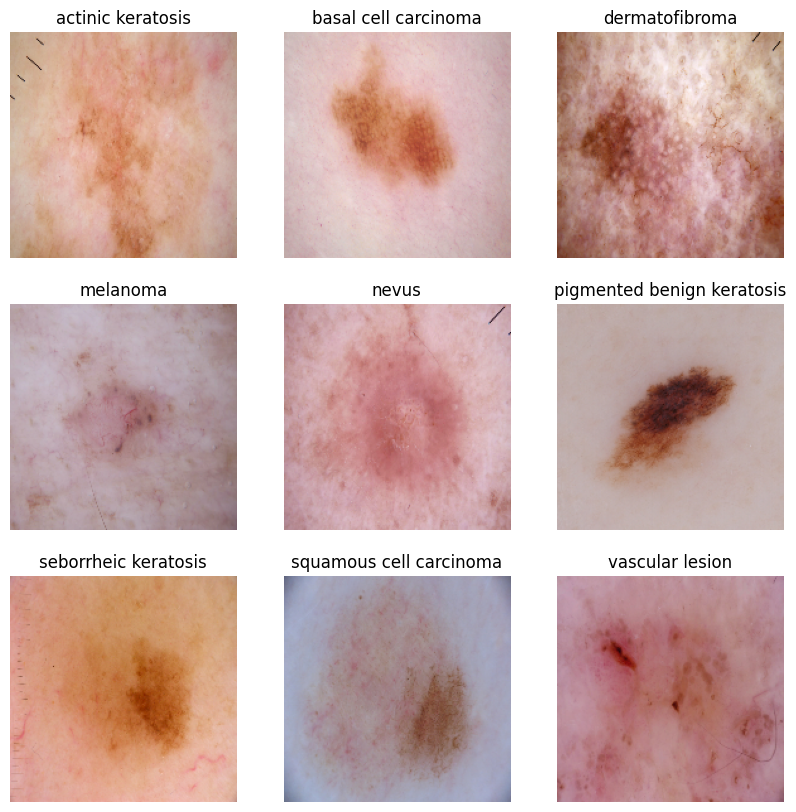

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [12]:
count= []
for path in pathlib.Path(train_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(train_dir)
                if os.path.isdir(os.path.join(train_dir, name))]

#return dataframe with image count and class.
df_train= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No.of Images in train dir'])
df_train

,Class_Name,No.of Images in train dir
0,vascular lesion,139
1,basal cell carcinoma,376
2,melanoma,438
3,actinic keratosis,114
4,squamous cell carcinoma,181
5,dermatofibroma,95
6,pigmented benign keratosis,462
7,nevus,357
8,seborrheic keratosis,77


In [16]:
count= []
for path in pathlib.Path(test_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(test_dir)
                if os.path.isdir(os.path.join(test_dir, name))]

#return dataframe with image count and class.
df_test= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No. of Images in test dir'])
df_test

,Class_Name,No. of Images in test dir
0,vascular lesion,3
1,nevus,16
2,pigmented benign keratosis,16
3,squamous cell carcinoma,16
4,seborrheic keratosis,3
5,dermatofibroma,16
6,actinic keratosis,16
7,melanoma,16
8,basal cell carcinoma,16


<Axes: xlabel='No. of Images in test dir', ylabel='Class_Name'>

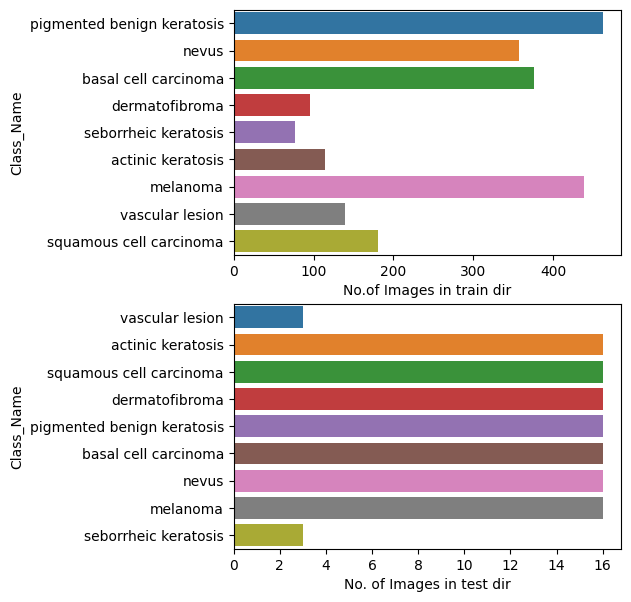

In [ ]:

plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
sns.barplot(x="No.of Images in train dir", y="Class_Name", data=df_train,
            label="Class_Name")
plt.subplot(2,1,2)
sns.barplot(x="No. of Images in test dir", y="Class_Name", data=df_test,
            label="Class")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
input_shape = (180,180,3)
lr = 1e-3
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(7, 7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense (9, activation='softmax'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 83, 83, 64)        100416    
                                                                 
 batch_normalization (BatchN  (None, 83, 83, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 41, 64)       0

Choose an appropirate optimiser and loss function for model training

In [ ]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

Train the model

In [ ]:
epochs = 20
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs,callbacks=[earlystop])

Epoch 1/20
56/56 [==============================] - 115s 465ms/step - loss: 21.6645 - accuracy: 0.2868 - val_loss: 37.6371 - val_accuracy: 0.2036
Epoch 2/20
56/56 [==============================] - 3s 56ms/step - loss: 13.3531 - accuracy: 0.3504 - val_loss: 31.5798 - val_accuracy: 0.0738
Epoch 3/20
56/56 [==============================] - 3s 57ms/step - loss: 6.4651 - accuracy: 0.3588 - val_loss: 6.5078 - val_accuracy: 0.1700
Epoch 4/20
56/56 [==============================] - 3s 57ms/step - loss: 3.3673 - accuracy: 0.3828 - val_loss: 3.8048 - val_accuracy: 0.2819
Epoch 5/20
56/56 [==============================] - 3s 56ms/step - loss: 2.1926 - accuracy: 0.4470 - val_loss: 3.3504 - val_accuracy: 0.2640
Epoch 6/20
56/56 [==============================] - 3s 57ms/step - loss: 1.9613 - accuracy: 0.4386 - val_loss: 2.6516 - val_accuracy: 0.1991
Epoch 7/20
56/56 [==============================] - 3s 56ms/step - loss: 1.6900 - accuracy: 0.4900 - val_loss: 1.8077 - val_accuracy: 0.4072
Epoch 

Visualizing training results

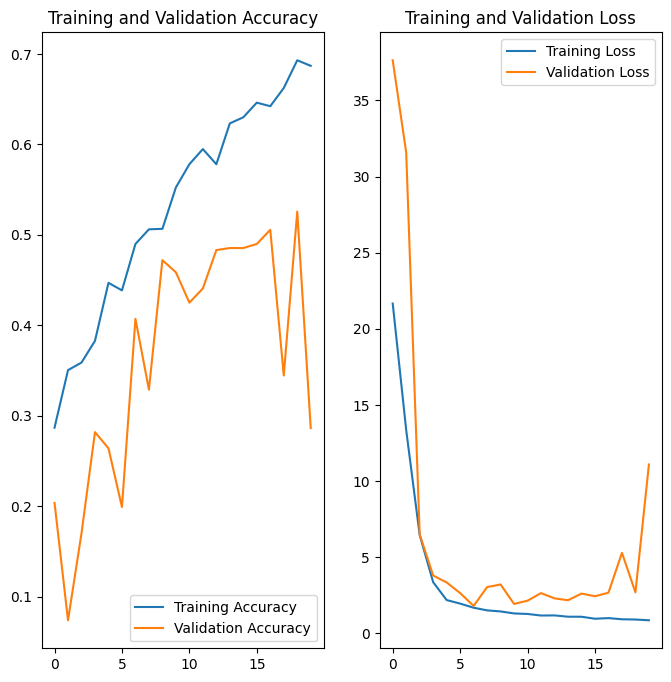

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 20
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
#check the model over fitting or under fitting
Training accuracy of the model seems to increase linearly whereas validation accuracy remained stagnant around 55%
High training accuracy means the model has learnt the noise in the data as well, however its poor performance on validation data shows lack of generalisability of the model.
The above observations confirm the case of overfitting. To mitigate overfitting augmentation technique will be used. Since the training data available is less, we will generate new samples by slightly modifying the existing training data (for eg. flipping the image horizontally/vertically, slightly rotating the image etc) and use them for training the model as well.

SyntaxError: invalid syntax (<ipython-input-20-1372298c78fe>, line 2)

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 16ms/step - loss: 11.0937 - accuracy: 0.2864
Accuracy:  0.3342633843421936
Validation Accuracy:  0.2863534688949585
Loss:  9.018878936767578
Validation Loss 11.093659400939941


Data is augumented to improve the model performance

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
        'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis',
         'squamous cell carcinoma','vascular lesion']
train_batches = datagen.flow_from_directory(train_dir,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(test_dir,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


Training the model after data augumentation

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 83, 83, 64)        100416    
                                                                 
 batch_normalization (BatchN  (None, 83, 83, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 41, 64)       0

In [ ]:
epochs = 20
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)
history = model.fit(train_batches, validation_data=valid_batches, epochs=epochs,callbacks=[earlystop])

Epoch 1/20
35/35 [==============================] - 114s 3s/step - loss: 1.7399 - accuracy: 0.4949 - val_loss: 217.4919 - val_accuracy: 0.1864
Epoch 2/20
35/35 [==============================] - 67s 2s/step - loss: 1.4881 - accuracy: 0.5400 - val_loss: 85.6691 - val_accuracy: 0.1864
Epoch 3/20
35/35 [==============================] - 67s 2s/step - loss: 1.3405 - accuracy: 0.5538 - val_loss: 4.6473 - val_accuracy: 0.3051
Epoch 4/20
35/35 [==============================] - 67s 2s/step - loss: 1.2895 - accuracy: 0.5574 - val_loss: 4.0461 - val_accuracy: 0.3559
Epoch 5/20
35/35 [==============================] - 67s 2s/step - loss: 1.2775 - accuracy: 0.5628 - val_loss: 5.8245 - val_accuracy: 0.2712
Epoch 6/20
35/35 [==============================] - 67s 2s/step - loss: 1.2104 - accuracy: 0.5770 - val_loss: 3.6114 - val_accuracy: 0.3390
Epoch 7/20
35/35 [==============================] - 67s 2s/step - loss: 1.2336 - accuracy: 0.5757 - val_loss: 4.3389 - val_accuracy: 0.4068
Epoch 8/20
35/35

plotting results

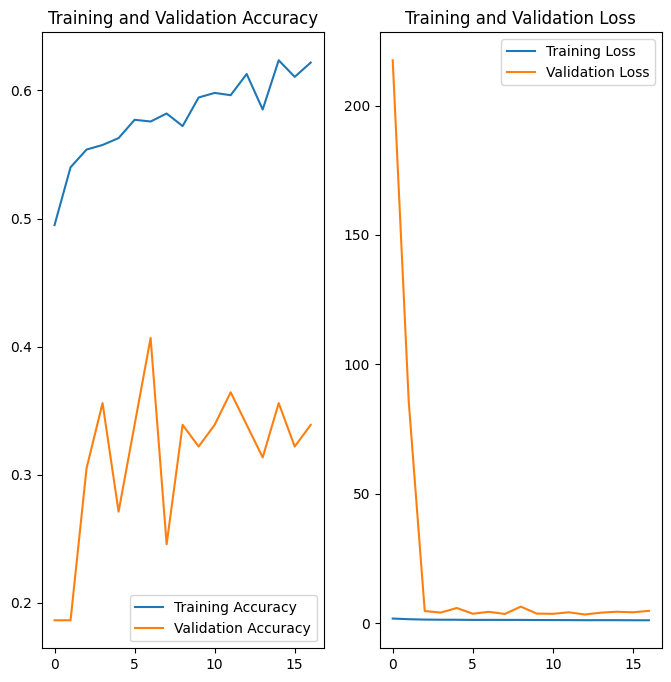

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 17
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 16ms/step - loss: 0.9227 - accuracy: 0.6600
Accuracy:  0.7154017686843872
Validation Accuracy:  0.6599552631378174
Loss:  0.8172679543495178
Validation Loss 0.9226523637771606


In [ ]:
count= []
for path in pathlib.Path(train_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(train_dir)
                if os.path.isdir(os.path.join(train_dir, name))]

#return dataframe with image count and class.
df_train= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No.of Images in train dir'])
df_train

,Class_Name,No.of Images in train dir
0,pigmented benign keratosis,462
1,nevus,357
2,basal cell carcinoma,376
3,dermatofibroma,95
4,seborrheic keratosis,77
5,actinic keratosis,114
6,melanoma,438
7,vascular lesion,139
8,squamous cell carcinoma,181


model performance is not improved. So
the imbalanced dataset has to be balanced.
using augumentations, increasing each class count to 500

In [17]:
!pip install Augmentor

In [18]:
import Augmentor

In [19]:
path_to_training_dataset= train_dir+"/"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Melonama/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B4430538E80>: 100%|██████████| 500/500 [00:23<00:00, 21.19 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Melonama/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B44304F7640>: 100%|██████████| 500/500 [00:22<00:00, 21.84 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Melonama/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B443031A410>: 100%|██████████| 500/500 [00:21<00:00, 23.46 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Melonama/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B44304954B0>: 100%|██████████| 500/500 [01:35<00:00,  5.24 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Melonama/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7B4430538E80>: 100%|██████████| 500/500 [01:24<00:00,  5.93 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Melonama/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B4448099A20>: 100%|██████████| 500/500 [00:18<00:00, 27.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Melonama/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B4430582410>: 100%|██████████| 500/500 [00:42<00:00, 11.76 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Melonama/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B443051E7D0>: 100%|██████████| 500/500 [00:19<00:00, 25.31 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Melonama/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B44304B5DE0>: 100%|██████████| 500/500 [00:18<00:00, 27.25 Samples/s]


In [ ]:
image_count_train = len(list(pathlib.Path(train_dir).glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
path_list = [x for x in glob.glob(os.path.join(pathlib.Path(train_dir), '*','output', '*.jpg'))]

In [ ]:
Balanced_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(train_dir, '*','output', '*.jpg'))]


In [ ]:
dataframe_dict_new = dict(zip(path_list, Balanced_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
dermatofibroma                500
seborrheic keratosis          500
actinic keratosis             500
melanoma                      500
vascular lesion               500
squamous cell carcinoma       500
Name: Label, dtype: int64

In [ ]:
data_dir_train="/content/drive/MyDrive/Melonama/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
input_shape = (180,180,3)
lr = 1e-4
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense (9, activation='softmax'))

## Number of classes is 9
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 39, 39, 128)      

In [ ]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Melonama/model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)

In [ ]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 1.8281 - accuracy: 0.3168
Epoch 1: val_accuracy improved from -inf to 0.42465, saving model to /content/drive/MyDrive/melonama/model.h5
169/169 [==============================] - 38s 204ms/step - loss: 1.8281 - accuracy: 0.3168 - val_loss: 1.5375 - val_accuracy: 0.4246
Epoch 2/30
168/169 [============================>.] - ETA: 0s - loss: 1.4662 - accuracy: 0.4451
Epoch 2: val_accuracy improved from 0.42465 to 0.49740, saving model to /content/drive/MyDrive/melonama/model.h5
169/169 [==============================] - 40s 230ms/step - loss: 1.4657 - accuracy: 0.4451 - val_loss: 1.3176 - val_accuracy: 0.4974
Epoch 3/30
168/169 [============================>.] - ETA: 0s - loss: 1.3319 - accuracy: 0.4909
Epoch 3: val_accuracy improved from 0.49740 to 0.53898, saving model to /content/drive/MyDrive/melonama/model.h5
169/169 [==============================] - 40s 231ms/step - loss: 1.3325 - accuracy: 0.4909 - val_loss: 1.24

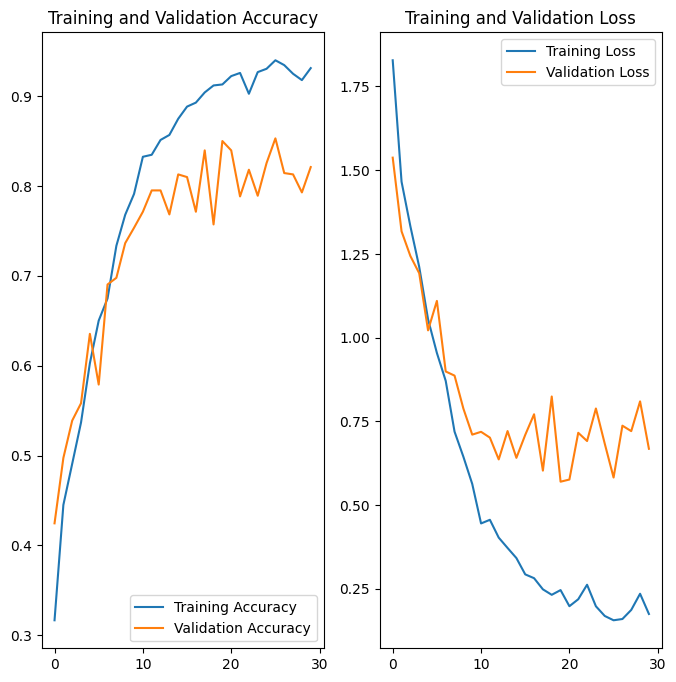

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 30 #edit here
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After balancing the data, From training accuracy and validation accuracy we can conclude that the model is stable val accuracy is 85.30  futher increasing the number of epochs will improve the accuracy.


In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 7s 136ms/step - loss: 0.6684 - accuracy: 0.8211
Accuracy:  0.9452893137931824
Validation Accuracy:  0.8210839033126831
Loss:  0.13610562682151794
Validation Loss 0.6683867573738098


**Model Predictions on Test Image**


1/1 [==============================] - 0s 21ms/step
Actual Class squamous cell carcinoma
Predictive Class squamous cell carcinoma


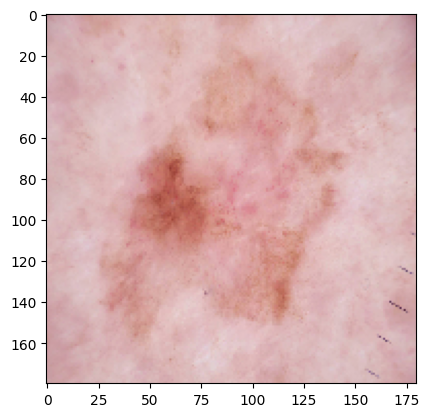

In [ ]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
class_names=os.listdir('/content/drive/MyDrive/Melonama/Test')
class_num=2
Test_image_path = os.path.join(pathlib.Path(test_dir), class_names[class_num], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)

pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[class_num] +'\n'+ "Predictive Class "+pred_class )